# XAI - homework 6

Mateusz Biesiadowski

## Raport

### Task 1

#### Description

We have two populations Blue (privileged) and Red (unprivileged), with the Blue population being 9 times larger than the Red population.

Individuals from both populations are requesting to attend XAI training to improve competency in this important area. Number of places is limited. The administrators of the training have decided to give priority to enrolling individuals who may need this training in the future, although unfortunately it is difficult to predict who will benefit.

The decision rule adopted:
1. In the Red group, half of the people will find the skills useful in future and half will not. Administrators randomly allocate 50% of people to training.
2. in the Blue group, 80% of people will find the training useful in future and 20% will not, although of course it is not known who will find it useful. The administrators have built a predictive model based on user behaviour in predicting for whom it will be useful and whom will not. The model has the following performance:


| Blue                     	| Will use XAI 	| Will not use XAI 	| Total 	|
|--------------------------	|--------------	|------------------	|-------	|
| Enrolled in training     	| 60           	| 5               	| 65    	|
| not enrolled in training 	| 20            | 15               	| 35    	|
| Total                    	| 80           	| 20               	| 100   	|


Task: Calculate the Demographic parity, equal opportunity and predictive rate parity coefficients for this decision rule.

Starred task: How can this decision rule be changed to improve its fairness?

#### Solution

##### Demographic parity

$DP = \frac{P(\hat{y} = 1 | A = red)}{P(\hat{y} = 1 | A = blue)}$  

- Red group:

$P(\hat{y} = 1 | A = red) = 0.5$

- Blue group:

$P(\hat{y} = 1 | A = blue) = 65 / 100 = 0.65$

- DP:

$DP = \frac{0.5}{0.65} = 76.92\% $

DP is under 80%, so it seems that classes are not balanced.

##### Equal opportunity

$TPR = \frac{P(\hat{y} = 1 | A = red, Y = 1)}{P(\hat{y} = 1 | A = blue, Y = 1)}$  

- Red group:

$P(\hat{y} = 1 | A = red, Y = 1) = 0.5$

- Blue group:

$P(\hat{y} = 1 | A = blue, Y = 1) = \frac{60}{60 + 20} = 6/8$

- TPR

$TPR = \frac{4/8}{6/8} = \frac{4}{6} = 66.67\%$

Again TPR is under 80%, so it does not satisfy 4/5 rule.

##### Positive Predictive Parity

$PPV = \frac{P(Y = 1 | A = red, \hat{Y} = 1)}{P(Y = 1 | A = blue, \hat{Y} = 1)}$  

- Red group:

$P(Y = 1 | A = red, \hat{Y} = 1) = 0.5$

- Blue group:

$P(Y = 1 | A = blue, \hat{Y} = 1) = \frac{60}{60 + 5} = 12/13$

- PPV

$PPV = \frac{5/10}{12/13} = 54.17\%$

Also PPV does not satisfy 4/5 rule.

##### Negative Predictive Parity

$NPV = \frac{P(Y = 1 | A = red, \hat{Y} = 0)}{P(Y = 1 | A = blue, \hat{Y} = 0)}$  

- Red group:

$P(Y = 1 | A = red, \hat{Y} = 1) = 0.5$

- Blue group:

$P(Y = 1 | A = blue, \hat{Y} = 1) = \frac{20}{20 + 15} = 4/7$

- NPV

$NPV = \frac{5/10}{4/7} = 87.5\%$

Only NPV satisfy 4/5 rule.

### Task 2

#### 2) For the selected protected attribute (age, gender, race) calculate the following fairness coefficients: Statistical parity, Equal opportunity, Predictive parity.

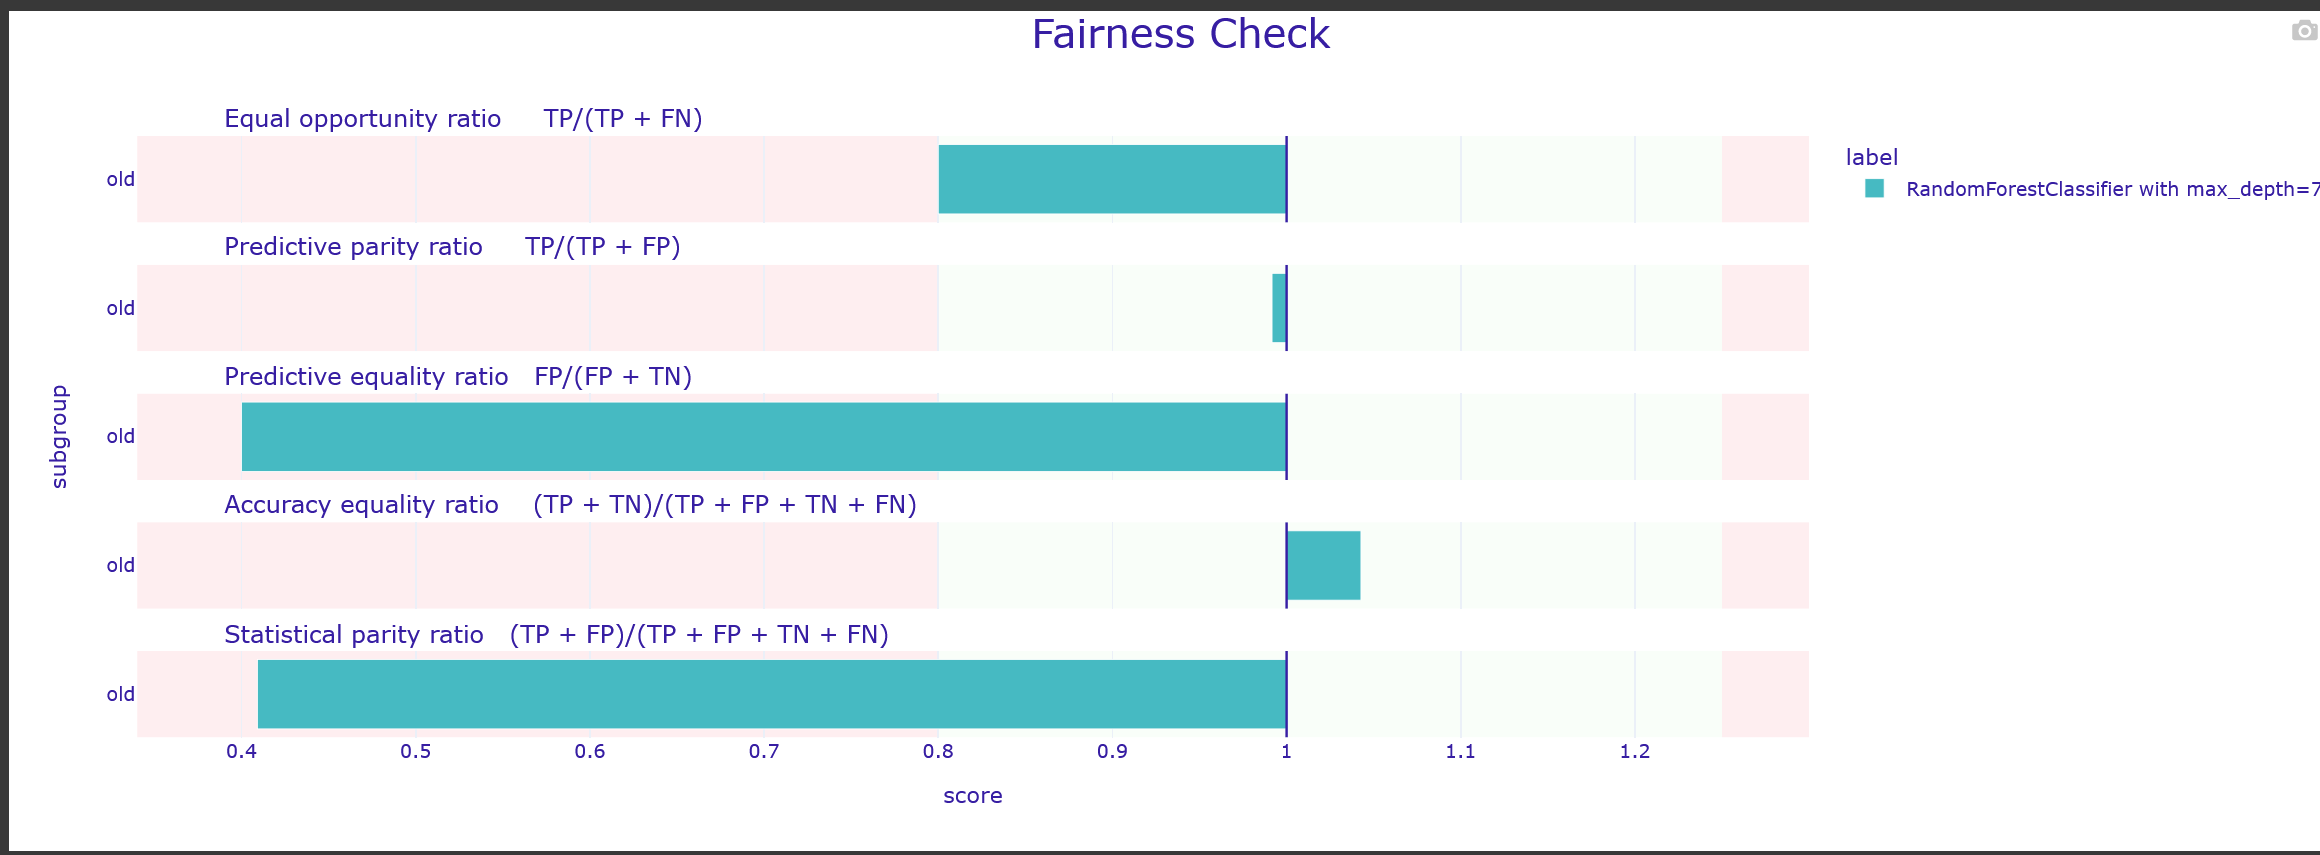

#### 3) Train another model (different hyperparameters, feature transformations etc.) and see how the coefficients Statistical parity, Equal opportunity, Predictive parity behave for it.

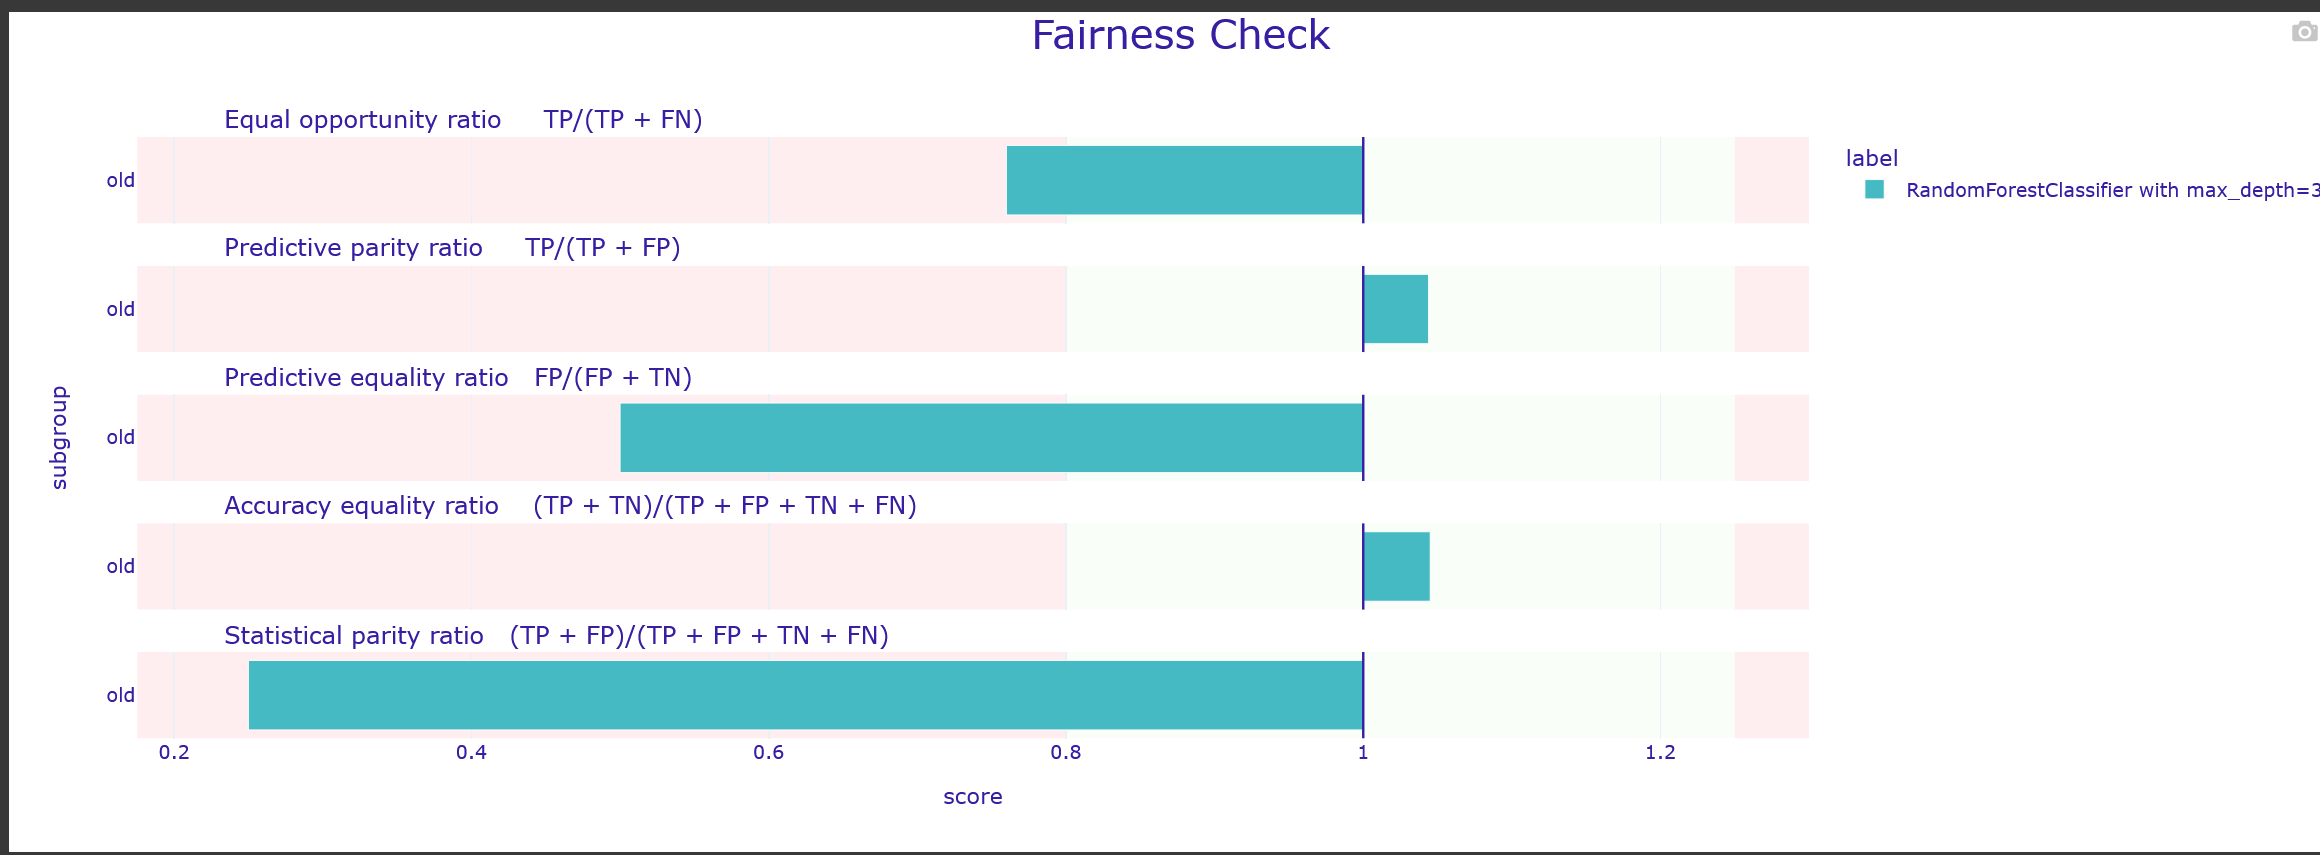

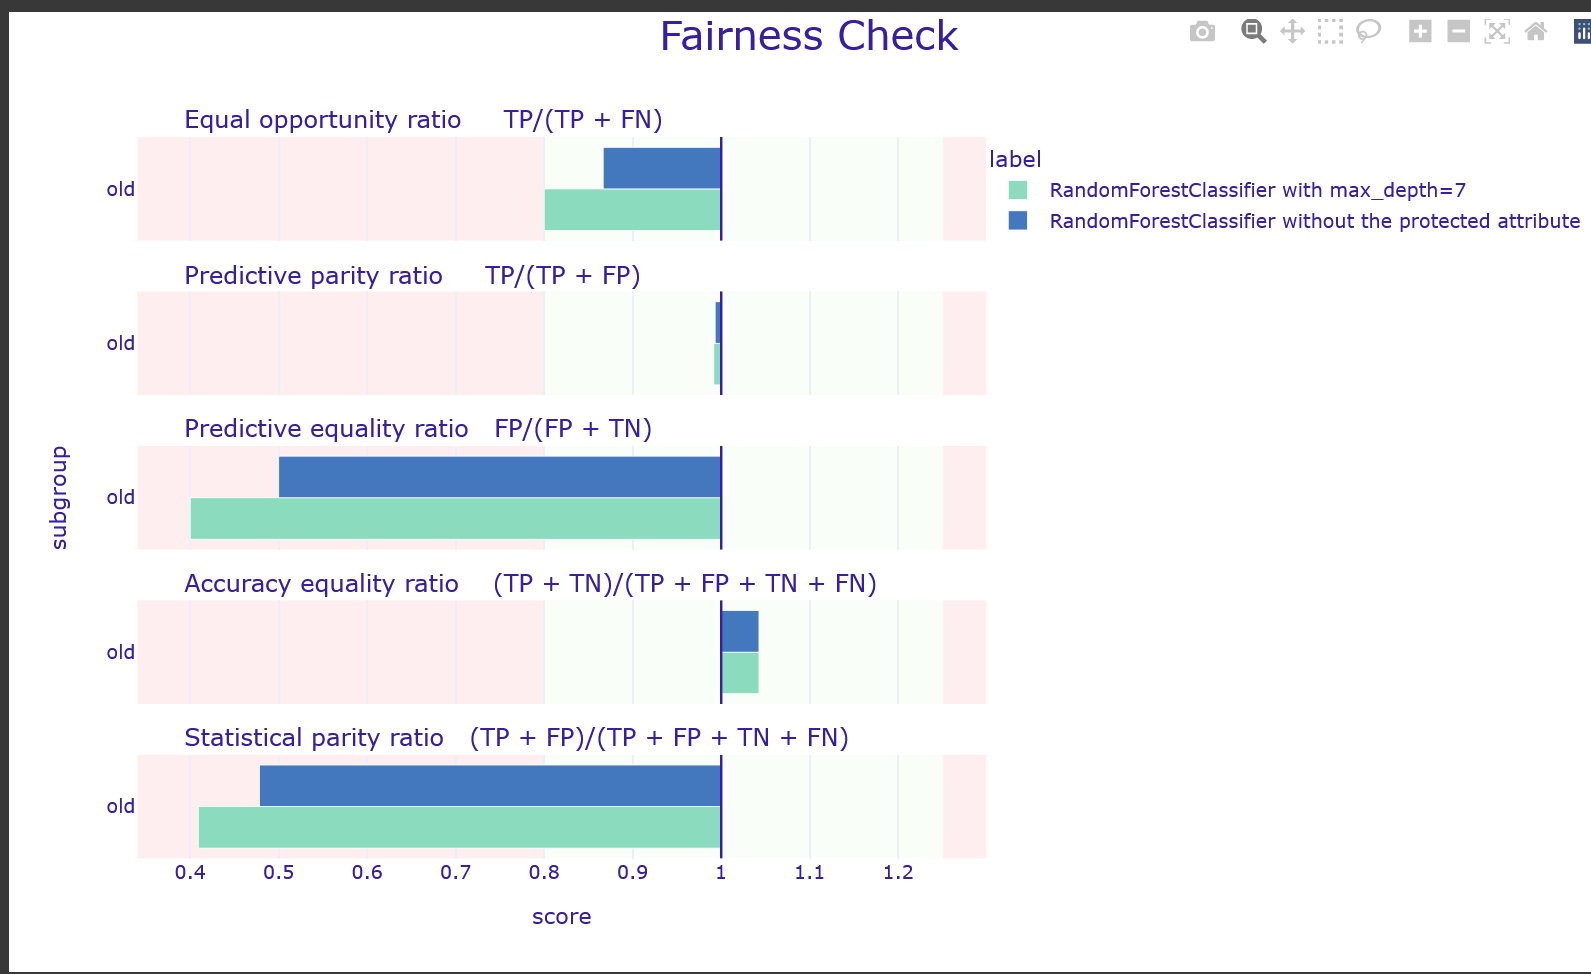

#### 4) Apply the selected bias mitigation technique on the first model. Check how Statistical parity, Equal opportunity, Predictive parity coefficients behave after this correction.

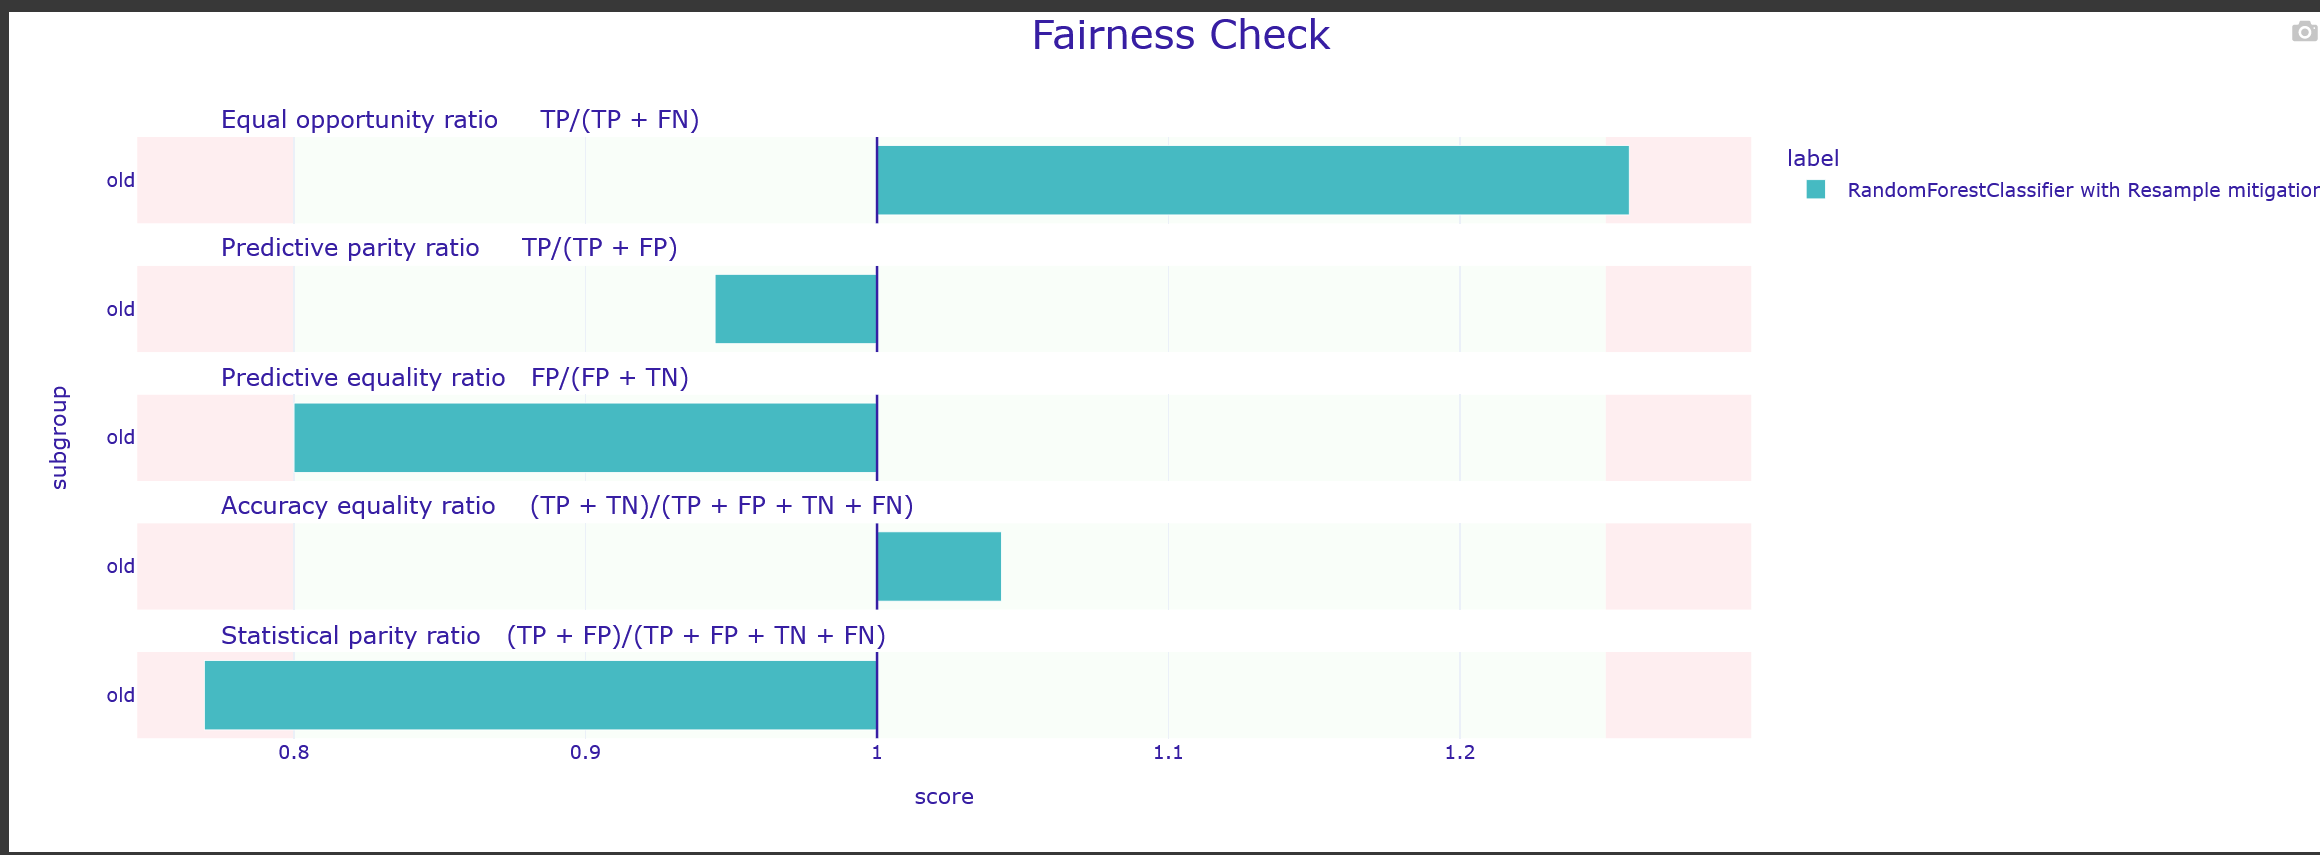

#### 5) Compare the quality (performance) of the three models with their fairness coefficients. Is there any correlation?

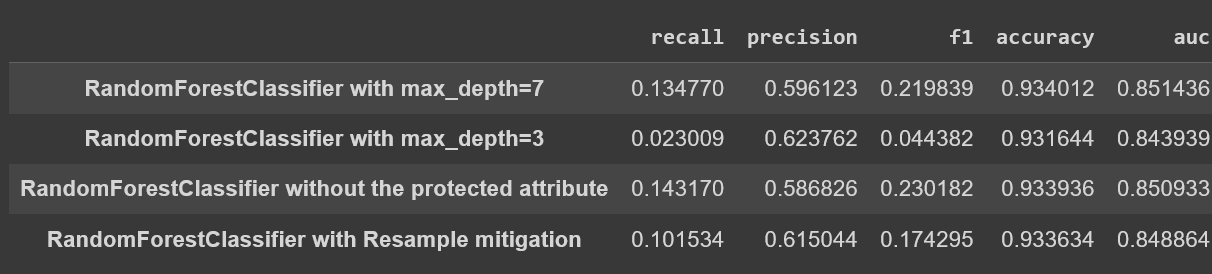

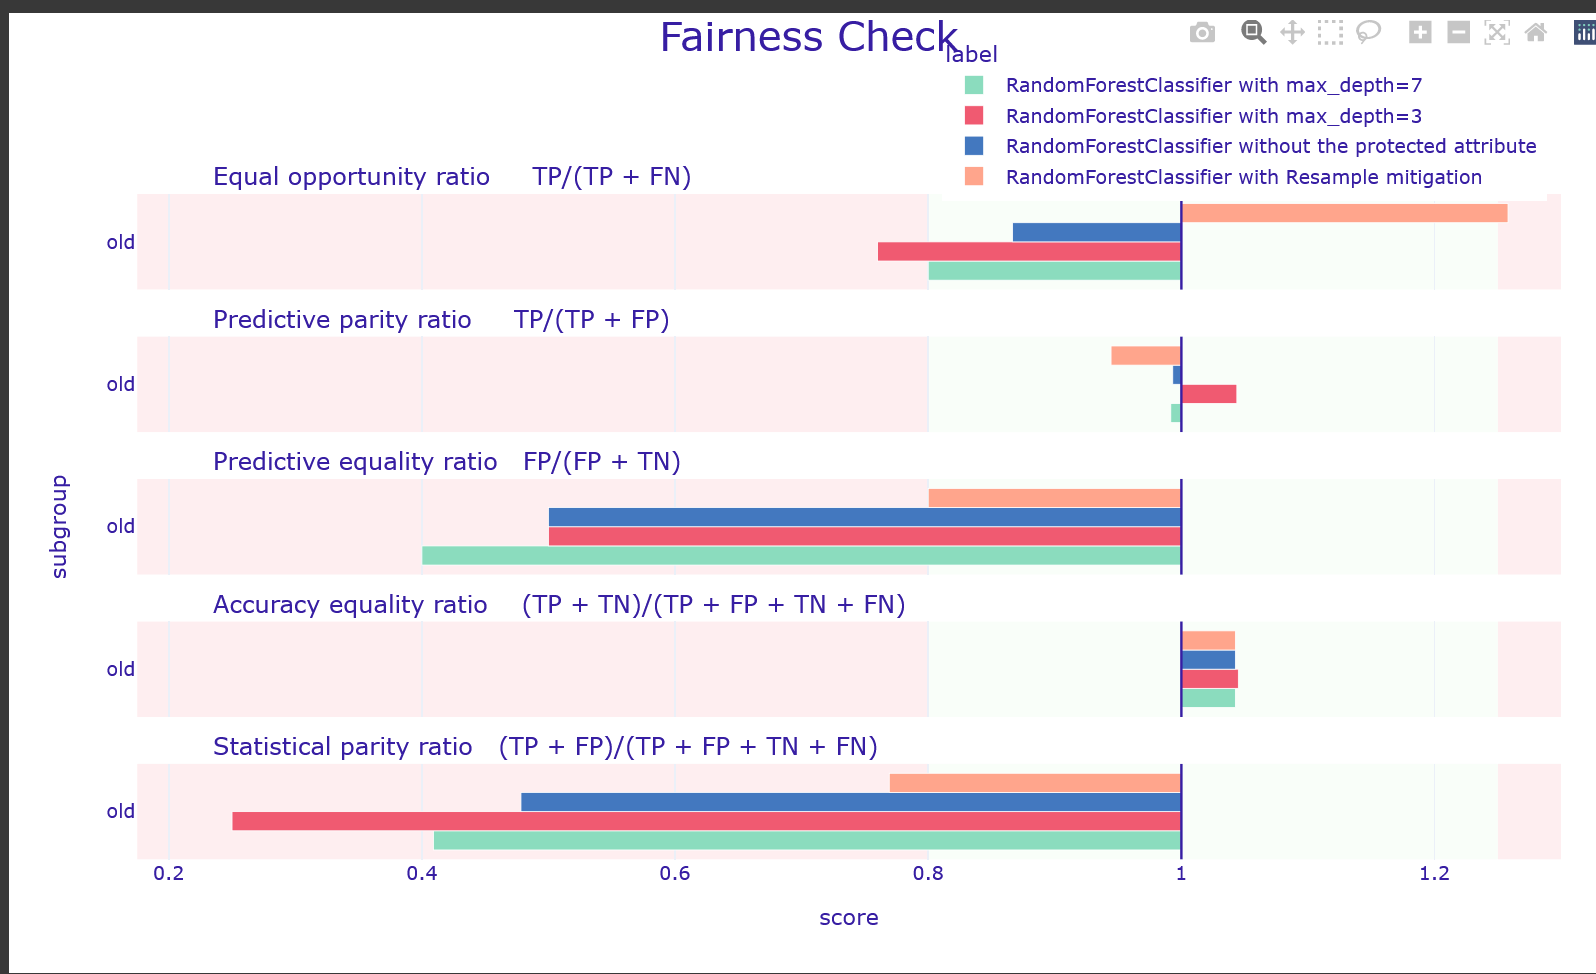

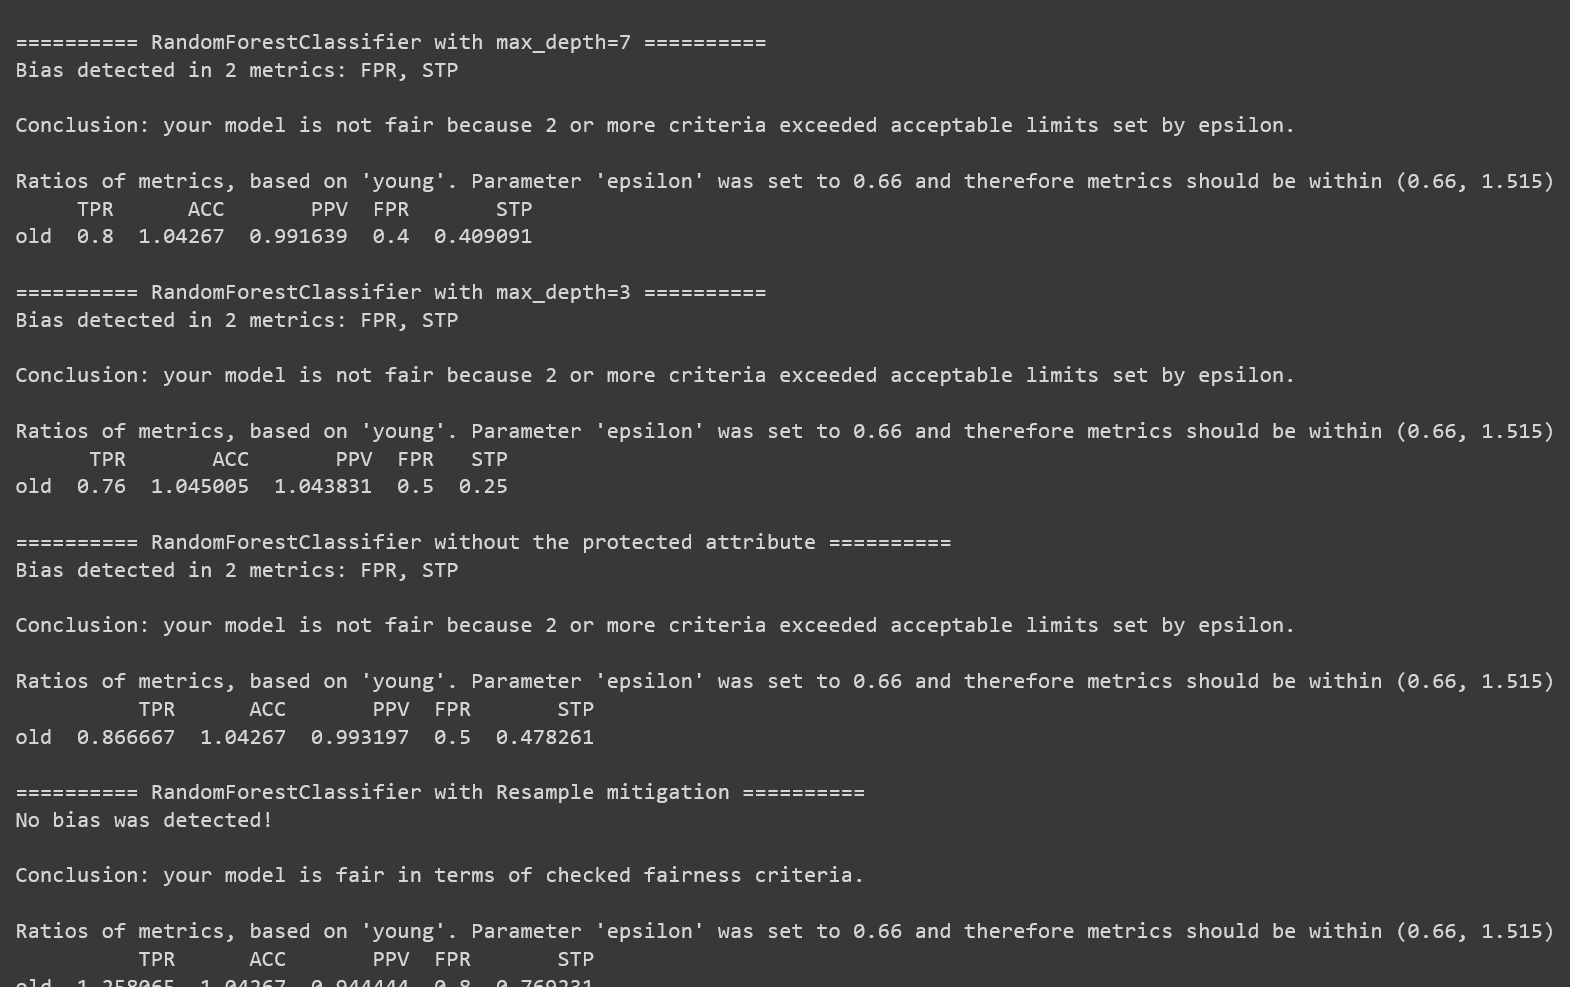

## Appendix

### Imports

In [1]:
!pip install dalex 1> /dev/null
!pip install shap 1> /dev/null
!pip install lime 1> /dev/null

In [73]:
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lime
import shap
import dalex as dx

from copy import copy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from dalex.fairness import resample, reweight, roc_pivot

In [3]:
#@title Set Credentials

kaggle_username = '' #@param {type:"string"}
kaggle_api_key = '' #@param {type:"string"}

try:
    import kaggle
except OSError:
    with open("/root/.kaggle/kaggle.json", "w+") as f:
        f.write('{"username":"' + kaggle_username + '","key":"' + kaggle_api_key + '"}')

os.system("chmod 600 /root/.kaggle/kaggle.json")

0

### Data

#### Download dataset

In [6]:
!kaggle datasets download -d brycecf/give-me-some-credit-dataset
!unzip /content/give-me-some-credit-dataset.zip

give-me-some-credit-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/give-me-some-credit-dataset.zip
  inflating: Data Dictionary.xls     
  inflating: cs-test.csv             
  inflating: cs-training.csv         
  inflating: sampleEntry.csv         


#### Get data

In [7]:
df = pd.read_csv("/content/cs-training.csv")

In [8]:
df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


### Preprocessing

#### Config

In [9]:
RANDOM_STATE = 2137
TEST_SIZE = 0.33

In [13]:
df_clean = df.dropna()

#### Split data

In [16]:
X, y = df_clean.drop('SeriousDlqin2yrs', axis=1), df_clean.SeriousDlqin2yrs

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Model

In [18]:
model_rf = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=RANDOM_STATE)

model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=150, random_state=2137)

In [19]:
def pf_rf_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(model_rf, X_test, y_test, predict_function=pf_rf_classifier_categorical, label="RandomForestClassifier with max_depth=7")

Preparation of a new explainer is initiated

  -> data              : 39689 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 39689 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RandomForestClassifier with max_depth=7
  -> predict function  : <function pf_rf_classifier_categorical at 0x7f389a08d310> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0106, mean = 0.0708, max = 0.776
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.709, mean = -0.00178, max = 0.989
  -> model_info        : package sklearn

A new explainer has been created!


#### Evaluate

In [20]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
RandomForestClassifier with max_depth=7,0.13477,0.596123,0.219839,0.934012,0.851436


#### Fairness

In [62]:
protected_variable = X_test.age.apply(lambda x: "old" if x > 50 else "young")
privileged_group = "young"

fobject = explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

In [63]:
fobject.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'young'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
     TPR      ACC       PPV  FPR       STP
old  0.8  1.04267  0.991639  0.4  0.409091


In [64]:
fobject.plot()

### Train another model (different hyperparameters, feature transformations etc.) and see how the coefficients Statistical parity, Equal opportunity, Predictive parity behave for it.

In [65]:
model_rf_shallow = RandomForestClassifier(n_estimators=150, max_depth=3, random_state=RANDOM_STATE)

model_rf_shallow.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=150, random_state=2137)

In [66]:
explainer_shallow = dx.Explainer(model_rf_shallow, X_test, y_test, predict_function=pf_rf_classifier_categorical, label="RandomForestClassifier with max_depth=3")

Preparation of a new explainer is initiated

  -> data              : 39689 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 39689 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RandomForestClassifier with max_depth=3
  -> predict function  : <function pf_rf_classifier_categorical at 0x7f389a08d310> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0264, mean = 0.0705, max = 0.536
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.523, mean = -0.00155, max = 0.973
  -> model_info        : package sklearn

A new explainer has been created!


#### Evaluate

In [67]:
explainer_shallow.model_performance()

,recall,precision,f1,accuracy,auc
RandomForestClassifier with max_depth=3,0.023009,0.623762,0.044382,0.931644,0.843939


#### Fairness

In [68]:
fobject_shallow = explainer_shallow.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

In [69]:
fobject_shallow.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'young'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
      TPR       ACC       PPV  FPR   STP
old  0.76  1.045005  1.043831  0.5  0.25


In [70]:
fobject_shallow.plot()

### Apply the selected bias mitigation technique on the first model. Check how Statistical parity, Equal opportunity, Predictive parity coefficients behave after this correction.

Check model without protected value

In [71]:
X_train_without_prot, X_test_without_prot = X_train.drop("age", axis=1), X_test.drop("age", axis=1)

model_without_prot = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=RANDOM_STATE)

model_without_prot.fit(X_train_without_prot, y_train)

explainer_without_prot = dx.Explainer(
    model_without_prot, 
    X_test_without_prot, 
    y_test,
    predict_function=pf_rf_classifier_categorical,
    label="RandomForestClassifier without the protected attribute",
    verbose=False
)

fobject_without_prot = explainer_without_prot.model_fairness(protected_variable, privileged_group)

In [72]:
fobject.plot(fobject_without_prot, show=False).\
    update_layout(autosize=False, width=1000, height=600, legend=dict(yanchor="top", y=0.999, xanchor="left", x=0.999))

In [74]:
protected_variable_train = X_train.age.apply(lambda x: "old" if x > 50 else "young")

# resample
indices_resample = resample(
    protected_variable_train, 
    y_train, 
    type='preferential', # uniform
    probs=model_without_prot.predict_proba(X_train_without_prot)[:, 1], # requires probabilities
    verbose=False
)
model_resample = copy(model_without_prot)
model_resample.fit(X_train_without_prot.iloc[indices_resample, :], y_train.iloc[indices_resample])
explainer_resample = dx.Explainer(
    model_resample, 
    X_test_without_prot, 
    y_test, 
    label='RandomForestClassifier with Resample mitigation',
    verbose=False
)
fobject_resample = explainer_resample.model_fairness(
    protected_variable, 
    privileged_group
)


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [86]:
fobject_resample.fairness_check()

Bias detected in 2 metrics: TPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'young'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
          TPR      ACC       PPV  FPR       STP
old  1.258065  1.04267  0.944444  0.8  0.769231


In [88]:
fobject_resample.plot()

#### Plot results

Models performance

In [76]:
pd.concat([
    explainer.model_performance().result,
    explainer_shallow.model_performance().result,
    explainer_without_prot.model_performance().result, 
    explainer_resample.model_performance().result,
], axis=0)

,recall,precision,f1,accuracy,auc
RandomForestClassifier with max_depth=7,0.134770,0.596123,0.219839,0.934012,0.851436
RandomForestClassifier with max_depth=3,0.023009,0.623762,0.044382,0.931644,0.843939
RandomForestClassifier without the protected attribute,0.143170,0.586826,0.230182,0.933936,0.850933
RandomForestClassifier with Resample mitigation,0.101534,0.615044,0.174295,0.933634,0.848864


Models Fairness

In [85]:
fobject.plot([fobject_shallow, fobject_without_prot, fobject_resample,], show=False).\
    update_layout(autosize=False, width=1000, height=600, legend=dict(yanchor="bottom", y=0.99, xanchor="right", x=0.99))

In [87]:
for fobj in [fobject, fobject_shallow, fobject_without_prot, fobject_resample]:
    print("\n========== " + fobj.label + " ==========")
    fobj.fairness_check(epsilon=0.66)


========== RandomForestClassifier with max_depth=7 ==========
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'young'. Parameter 'epsilon' was set to 0.66 and therefore metrics should be within (0.66, 1.515)
     TPR      ACC       PPV  FPR       STP
old  0.8  1.04267  0.991639  0.4  0.409091

========== RandomForestClassifier with max_depth=3 ==========
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'young'. Parameter 'epsilon' was set to 0.66 and therefore metrics should be within (0.66, 1.515)
      TPR       ACC       PPV  FPR   STP
old  0.76  1.045005  1.043831  0.5  0.25

========== RandomForestClassifier without the protected attribute ==========
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or mo